In [1]:
import pandas as pd
import numpy as np
import warnings
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
warnings.filterwarnings('ignore')
from dataclasses import dataclass
from typing import Tuple
from tqdm.auto import tqdm

# Simulation

In [2]:
@dataclass
class ExpMarketParameters:
    """Market and model parameters"""
    q_min: int = -10
    q_max: int = 10
    T: float = 1.0  # Maximum time (minutes)
    dt: float = 0.001  # Time step
    gamma: float = 0.001  # Risk aversion
    phi: float = 0.001  # Penalty constant
    lambda_plus: float = 100  # Arrival rate of buy orders
    lambda_minus: float = 100  # Arrival rate of sell orders
    sigma: float = 0.25  # Volatility
    k: float = 50  # Arrival rate decay factor
    S0: float = 10  # Initial price
    N_s: int = 20  # Number of space steps
    ds: float = 0.1  # Space step

    def __post_init__(self):
        self.n = int(60/self.dt)
        self.T_range = int(self.T * self.n)
        self.q_range = np.arange(self.q_min, self.q_max + 1)
        self.S = np.linspace(
            self.S0 - 0.5*self.N_s*self.ds,
            self.S0 + 0.5*self.N_s*self.ds,
            self.N_s + 1
        )

class ExpMarketMaker:
    def __init__(self, params: ExpMarketParameters):
        self.params = params
        self.initialize_arrays()

    def initialize_arrays(self):
        S_len = len(self.params.S)
        q_len = len(self.params.q_range)

        self.Theta = np.zeros((S_len, self.params.T_range + 1, q_len))
        self.d1 = np.zeros((S_len, self.params.T_range + 1, q_len))
        self.d2 = np.zeros((S_len, self.params.T_range + 1, q_len))

        # Initialize terminal conditions
        for s in range(S_len):
            for q_id in range(q_len):
                self.Theta[s, -1, q_id] = self.params.q_range[q_id] * self.params.S[s]

    def solve_hjb(self):
        """Solve the HJB equation using finite differences"""
        for t in tqdm(range(self.params.T_range-1,-1,-1)):
            for s in range(len(self.params.S)):
                for q_id in range(len(self.params.q_range)):
                    self._update_controls(t, s, q_id)
                    self._update_value_function(t, s, q_id)

                # Handle boundary conditions
                self.Theta[s, t, 0] = self.Theta[s, t, 1] - self.params.S[s]
                self.Theta[s, t, -1] = self.Theta[s, t, -2] + self.params.S[s]
        # Assuming h, d1, d2, q_min, q_max, T_range are already defined
        q_range = np.arange(self.params.q_min, self.params.q_max+1)
        t_range = np.arange(0, self.params.T_range+1)*self.params.dt
        S_mid = int(self.params.N_s/2)

        Q, T = np.meshgrid(q_range, t_range)  # Create meshgrid for plotting

        # Plot bid
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.plot_surface(T, Q, self.d2[S_mid,:,:], cmap='viridis')
        ax1.set_title('Bid as function of q and t')
        ax1.set_xlabel('Time Remaining (s)')
        ax1.set_ylabel('Inventory q')
        ax1.set_zlabel('Bid')

        # Plot ask
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.plot_surface(T, Q, self.d1[S_mid,:,:], cmap='plasma')
        ax2.set_title('Ask as function of q and t')
        ax2.set_xlabel('Time Remaining (s)')
        ax2.set_ylabel('Inventory q')
        ax2.set_zlabel('Ask')

        plt.tight_layout()
        plt.show()

    def _update_controls(self, t: int, s: int, q_id: int):
        """Update optimal controls d1 and d2"""
        if q_id != 0:
          self.d1[s, t, q_id] = 1/self.params.gamma * np.log(self.params.k/(self.params.k-self.params.gamma)) - self.params.S[s] - (self.Theta[s, t+1, q_id-1] - self.Theta[s, t+1, q_id])

        if q_id != len(self.params.q_range) - 1:
          self.d2[s, t, q_id] = 1/self.params.gamma * np.log(self.params.k/(self.params.k-self.params.gamma))  + self.params.S[s] - (self.Theta[s, t+1, q_id+1] - self.Theta[s, t+1, q_id])

    def _update_value_function(self, t: int, s: int, q_id: int):
        """Update value function Theta"""
        if q_id in [0, len(self.params.q_range) - 1]:
            return

        # Calculate intensities
        a = b = 0

        if q_id != len(self.params.q_range) - 1:
            a = (-self.params.lambda_minus *
                np.exp(-self.params.k * self.d2[s, t, q_id]) *
                self.params.gamma / (self.params.k-self.params.gamma))
        if q_id != 0:
            b = (-self.params.lambda_plus *
                np.exp(-self.params.k * self.d1[s, t, q_id]) *
                self.params.gamma / (self.params.k-self.params.gamma))

        # Calculate diffusion terms
        term1 = self._calculate_term1(s, t, q_id)
        term2 = self._calculate_term2(s, t, q_id)

        q = self.params.q_range[q_id]

        penalty = self.params.phi*np.exp(-(self.params.T_range-t)*self.params.dt)*(q**2)
        self.Theta[s, t, q_id] = (self.Theta[s, t+1, q_id] +
            self.params.dt * (term1 + term2 + a + b - penalty))

    def _calculate_term1(self, s: int, t: int, q_id: int) -> float:
        if s == 0 or s == len(self.params.S) - 1:
            return 0
        return 0.5 * (self.params.sigma**2) * (
            (self.Theta[s+1, t+1, q_id] -
             2 * self.Theta[s, t+1, q_id] +
             self.Theta[s-1, t+1, q_id]) /
            self.params.ds**2)

    def _calculate_term2(self, s: int, t: int, q_id: int) -> float:
        if s == 0:
            deriv = ((self.Theta[s+1, t+1, q_id] -
                     self.Theta[s, t+1, q_id]) /
                    self.params.ds)
        else:
            deriv = ((self.Theta[s, t+1, q_id] -
                     self.Theta[s-1, t+1, q_id]) /
                    self.params.ds)
        return -0.5 * (self.params.sigma**2) * self.params.gamma * deriv**2

    def _get_q_id(self, q: float) -> int:
        """Convert inventory to array index"""
        q_bounded = np.clip(q, self.params.q_min, self.params.q_max)
        return int(q_bounded - self.params.q_min)

    def _get_s_idx(self, price: float) -> int:
        """Get closest price index"""
        return np.abs(self.params.S - price).argmin()

    def plot_results(self, inventory: np.ndarray, cash: np.ndarray, mid_price: np.ndarray):
        """Plot simulation results"""
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

        t = np.arange(len(inventory))
        pnl = cash + inventory * mid_price

        ax1.plot(t, inventory)
        ax1.set_title('Inventory Path')
        ax1.set_xlabel('Time Steps')
        ax1.set_ylabel('Inventory')
        ax1.grid(True)

        ax2.plot(t, cash)
        ax2.set_title('Cash Path')
        ax2.set_xlabel('Time Steps')
        ax2.set_ylabel('Cash')
        ax2.grid(True)

        ax3.plot(t, mid_price, label='Mid-Price')
        ax3_twin = ax3.twinx()
        ax3_twin.plot(t, pnl, 'r--', label='P&L')

        ax3.set_title('Mid-Price and P&L')
        ax3.set_xlabel('Time Steps')
        ax3.set_ylabel('Price')
        ax3_twin.set_ylabel('P&L')

        lines1, labels1 = ax3.get_legend_handles_labels()
        lines2, labels2 = ax3_twin.get_legend_handles_labels()
        ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        ax3.grid(True)
        plt.tight_layout()
        plt.show()

In [3]:
@dataclass
class MarketParameters:
    """Market and model parameters"""
    q_min: int = -25  # Largest short position possible
    q_max: int = 25   # Largest long position possible
    T: float = 1.0    # Maximum time to hold inventory (minutes)
    dt: float = 0.001  # Time step (breaking down each second to 100 ms)
    gamma: float = 0.001  # Risk aversion
    phi: float = 0.001    # Inventory penalty
    lambda_plus: float = 100  # Arrival rate of buy orders
    lambda_minus: float = 100  # Arrival rate of sell orders
    sigma: float = 0.25   # Volatility
    k: float = 50  # Arrival rate decay factor - buy orders
    k_minus: float = 50   # Arrival rate decay factor - sell orders

    def __post_init__(self):
        self.n = int(60/self.dt)
        self.T_range = int(self.T * self.n)

class MarketMaker:
    def __init__(self, params: MarketParameters):
        self.params = params
        self.initialize_arrays()

    def initialize_arrays(self):
        q_size = self.params.q_max - self.params.q_min + 1
        self.h = np.zeros((self.params.T_range+1, q_size))
        self.d1 = np.zeros((self.params.T_range+1, q_size))
        self.d2 = np.zeros((self.params.T_range+1, q_size))

        # Initialize terminal conditions
        for q in range(self.params.q_min, self.params.q_max + 1):
            q_id = q - self.params.q_min
            self.h[-1, q_id] = -self.params.gamma * np.power(q, 2)
            self.d1[-1, q_id] = 0
            self.d2[-1, q_id] = 0

    def solve_hjb(self):
        """Solve the HJB equation using finite differences"""
        for t in tqdm(range(self.params.T_range-1,-1,-1)):
            for q in range(self.params.q_min, self.params.q_max + 1):
                q_id = q - self.params.q_min

                # Calculate optimal delta and d
                if q != self.params.q_min:
                    self.d1[t, q_id] = 1/self.params.k - (
                        self.h[t+1, q_id-1] - self.h[t+1, q_id]
                    )

                if q != self.params.q_max:
                    self.d2[t, q_id] = 1/self.params.k - (
                        self.h[t+1, q_id+1] - self.h[t+1, q_id]
                    )

                # Calculate value function using DPP principles
                a = 0
                b = 0
                if q != self.params.q_max:
                    a = self.params.lambda_minus * np.exp(-self.params.k * self.d2[t, q_id]) / self.params.k
                if q != self.params.q_min:
                    b = self.params.lambda_plus * np.exp(-self.params.k * self.d1[t, q_id]) / self.params.k

                self.h[t, q_id] = self.h[t+1, q_id] + (
                    a + b - self.params.phi * np.exp(-(self.params.T_range-t) * self.params.dt) * np.power(q, 2)
                ) * self.params.dt
        # Assuming h, d1, d2, q_min, q_max, T_range are already defined
        q_range = np.arange(self.params.q_min, self.params.q_max+1)
        t_range = np.arange(0, self.params.T_range+1)*self.params.dt
        Q, T = np.meshgrid(q_range, t_range)  # Create meshgrid for plotting

        # Plot bid
        fig = plt.figure(figsize=(15, 5))
        ax1 = fig.add_subplot(121, projection='3d')
        ax1.plot_surface(T, Q, self.d2[:,:], cmap='viridis')
        ax1.set_title('Bid as function of q and t')
        ax1.set_xlabel('Time Remaining (s)')
        ax1.set_ylabel('Inventory q')
        ax1.set_zlabel('Bid')

        # Plot ask
        ax2 = fig.add_subplot(122, projection='3d')
        ax2.plot_surface(T, Q, self.d1[:,:], cmap='plasma')
        ax2.set_title('Ask as function of q and t')
        ax2.set_xlabel('Time Remaining (s)')
        ax2.set_ylabel('Inventory q')
        ax2.set_zlabel('Ask')

        plt.tight_layout()
        plt.show()

    def get_bounded_q_id(self, q: float) -> int:
        """Convert inventory to bounded array index"""
        q_bounded = np.clip(q, self.params.q_min, self.params.q_max)
        return int(q_bounded - self.params.q_min)

    def plot_results(self, inventory: np.ndarray, cash: np.ndarray, mid_price: np.ndarray):
        fig, (ax1, ax2, ax3) = plt.subplots(3, 1, figsize=(12, 10))

        t = np.arange(len(inventory))

        # Calculate P&L
        pnl = cash + inventory * mid_price

        ax1.plot(t, inventory)
        ax1.set_title('Inventory Path')
        ax1.set_xlabel('Time Steps')
        ax1.set_ylabel('Inventory')
        ax1.grid(True)

        ax2.plot(t, cash)
        ax2.set_title('Cash Path')
        ax2.set_xlabel('Time Steps')
        ax2.set_ylabel('Cash')
        ax2.grid(True)

        # Plot both mid-price and P&L on the same axis
        ax3.plot(t, mid_price, label='Mid-Price')
        ax3_twin = ax3.twinx()  # Create second y-axis
        ax3_twin.plot(t, pnl, 'r--', label='P&L')

        ax3.set_title('Mid-Price and P&L')
        ax3.set_xlabel('Time Steps')
        ax3.set_ylabel('Price')
        ax3_twin.set_ylabel('P&L')

        # Add legends
        lines1, labels1 = ax3.get_legend_handles_labels()
        lines2, labels2 = ax3_twin.get_legend_handles_labels()
        ax3.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

        ax3.grid(True)
        plt.tight_layout()
        plt.show()

In [4]:
@dataclass
class ComparisonParameters:
    """Combined parameters for both models"""
    # Basic market parameters
    T: float = 5/60  # Maximum time (minutes)
    dt: float = .0001  # Time step

    # Inventory parameters
    q_min: int = -10
    q_max: int = 10

    # Market parameters
    gamma: float = 0.001  # Risk aversion
    phi: float = 0.001  # Inventory penalty
    lambda_plus: float = 100  # Arrival rate of buy orders
    lambda_minus: float = 100  # Arrival rate of sell orders
    sigma: float = 0.25  # Volatility
    k: float = 50  # Arrival rate decay factor
    S0: float = 100  # Initial price

    # Extended model specific parameters
    N_s: int = 40  # Number of space steps for extended model
    ds: float = 0.1  # Space step for extended model

    def __post_init__(self):
        self.n = int(60/self.dt)
        self.T_range = int(self.T * self.n)
        self.n_steps: int = self.T_range  # Number of simulation steps

class Models:
    """Combined parameters for both models"""
    # Basic market parameters
    T: float = 5/60  # Maximum time (minutes)
    dt: float = .0001  # Time step

    # Inventory parameters
    q_min: int = -10
    q_max: int = 10

    # Market parameters
    gamma: float = 0.001  # Risk aversion
    phi: float = 0.001  # Inventory penalty
    lambda_plus: float = 100  # Arrival rate of buy orders
    lambda_minus: float = 100  # Arrival rate of sell orders
    sigma: float = 0.25  # Volatility
    k: float = 50  # Arrival rate decay factor
    S0: float = 100  # Initial price

    # Extended model specific parameters
    N_s: int = 40  # Number of space steps for extended model
    ds: float = 0.1  # Space step for extended model

    def __init__(self, params: ComparisonParameters):
        self.params = params
        print("Basic Model ..")
        self.basic_mm = MarketMaker(self._create_basic_params())
        self.basic_mm.solve_hjb()

        print("Exponential Model ..")
        self.exp_mm = ExpMarketMaker(self._create_exp_params())
        self.exp_mm.solve_hjb()

    def _create_basic_params(self):
        return MarketParameters(
            q_min=self.params.q_min,
            q_max=self.params.q_max,
            T=self.params.T,
            dt=self.params.dt,
            gamma=self.params.gamma,
            phi=self.params.phi,
            lambda_plus=self.params.lambda_plus,
            lambda_minus=self.params.lambda_minus,
            sigma=self.params.sigma,
            k=self.params.k,
            k_minus=self.params.k
        )

    def _create_exp_params(self):
        return ExpMarketParameters(
            q_min=self.params.q_min,
            q_max=self.params.q_max,
            T=self.params.T,
            dt=self.params.dt,
            gamma=self.params.gamma,
            phi=self.params.phi,
            lambda_plus=self.params.lambda_plus,
            lambda_minus=self.params.lambda_minus,
            sigma=self.params.sigma,
            k=self.params.k,
            S0=self.params.S0,
            N_s=self.params.N_s,
            ds=self.params.ds
        )


In [14]:
class CombinedMarketMaker:
    def __init__(self, params: ComparisonParameters, mm_models: Models):
        self.params = params
        print("Loading Models....")
        self.basic_mm = mm_models.basic_mm
        self.exp_mm = mm_models.exp_mm

    def simulate_combined_trading(self) -> Tuple[dict, dict, np.ndarray]:
        """Simulate trading with same random paths for both models"""
        # Initialize arrays
        factor = 100
        basic_inventory = np.zeros(int(self.params.n_steps/factor))
        basic_cash = np.zeros(int(self.params.n_steps/factor))
        exp_inventory = np.zeros(int(self.params.n_steps/factor))
        exp_cash = np.zeros(int(self.params.n_steps/factor))
        mid_price = self.params.S0 * np.ones(int(self.params.n_steps/factor))

        # Pre-generate random paths
        # np.random.seed(42)  # For reproducibility
        price_changes = self.params.sigma * np.sqrt(self.params.dt*factor) * np.random.randn(int(self.params.n_steps/factor))
        ask_randoms = np.random.random(int(self.params.n_steps/factor))
        bid_randoms = np.random.random(int(self.params.n_steps/factor))

        current_time = 0
        s_idx = len(self.exp_mm.params.S) // 2

        for t in (range(0, int(self.params.n_steps/factor))):
            current_time = min(t*factor, self.params.T_range)
            # Get current positions
            basic_q_id = self.basic_mm.get_bounded_q_id(basic_inventory[t-1])
            exp_q_id = self.exp_mm._get_q_id(exp_inventory[t-1])

            # Get spreads for both models
            basic_ask = self.basic_mm.d1[current_time, basic_q_id]
            basic_bid = self.basic_mm.d2[current_time, basic_q_id]
            exp_ask = self.exp_mm.d1[s_idx, current_time, exp_q_id]
            exp_bid = self.exp_mm.d2[s_idx, current_time, exp_q_id]

            # Update price using pre-generated random path
            mid_price[t] = mid_price[t-1] + price_changes[t]
            s_idx = self.exp_mm._get_s_idx(mid_price[t])

            # Calculate order executions using same random numbers
            basic_ask_intensity = self.params.lambda_plus * np.exp(-self.params.k * basic_ask)
            basic_bid_intensity = self.params.lambda_minus * np.exp(-self.params.k * basic_bid)
            exp_ask_intensity = self.params.lambda_plus * np.exp(-self.params.k * exp_ask)
            exp_bid_intensity = self.params.lambda_minus * np.exp(-self.params.k * exp_bid)

            # Use pre-generated random numbers for order execution
            basic_ask_executed = ask_randoms[t] < basic_ask_intensity * self.params.dt*factor
            basic_bid_executed = bid_randoms[t] < basic_bid_intensity * self.params.dt*factor
            exp_ask_executed = ask_randoms[t] < exp_ask_intensity * self.params.dt*factor
            exp_bid_executed = bid_randoms[t] < exp_bid_intensity * self.params.dt*factor

            # Update basic model
            if basic_ask_executed and basic_inventory[t-1] > self.params.q_min+2:
                basic_inventory[t] = basic_inventory[t-1] - 1
                basic_cash[t] = basic_cash[t-1] + mid_price[t] + basic_ask
            elif basic_bid_executed and basic_inventory[t-1] < self.params.q_max-2:
                basic_inventory[t] = basic_inventory[t-1] + 1
                basic_cash[t] = basic_cash[t-1] - (mid_price[t] - basic_bid)
            else:
                basic_inventory[t] = basic_inventory[t-1]
                basic_cash[t] = basic_cash[t-1]

            # Update extended model
            if exp_ask_executed and exp_inventory[t-1] > self.params.q_min+2:
                exp_inventory[t] = exp_inventory[t-1] - 1
                exp_cash[t] = exp_cash[t-1] + mid_price[t] + exp_ask
            elif exp_bid_executed and exp_inventory[t-1] < self.params.q_max-2:
                exp_inventory[t] = exp_inventory[t-1] + 1
                exp_cash[t] = exp_cash[t-1] - (mid_price[t] - exp_bid)
            else:
                exp_inventory[t] = exp_inventory[t-1]
                exp_cash[t] = exp_cash[t-1]

        basic_results = {
            'inventory': basic_inventory,
            'cash': basic_cash,
            'pnl': basic_cash + basic_inventory * mid_price
        }

        exp_results = {
            'inventory': exp_inventory,
            'cash': exp_cash,
            'pnl': exp_cash + exp_inventory * mid_price
        }

        return basic_results, exp_results, mid_price

    def plot_comparison(self, basic_results: dict, exp_results: dict, mid_price: np.ndarray):
        """Plot comparison of both models' results"""
        fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

        t = np.arange(len(mid_price))

        # Plot inventories
        ax1.plot(t, basic_results['inventory'], label='Basic Model', alpha=0.7)
        ax1.plot(t, exp_results['inventory'], label='Extended Model', alpha=0.7)
        ax1.set_title('Inventory Comparison')
        ax1.set_xlabel('Time Steps')
        ax1.set_ylabel('Inventory')
        ax1.legend()
        ax1.grid(True)

        # Plot cash positions
        ax2.plot(t, basic_results['cash'], label='Basic Model', alpha=0.7)
        ax2.plot(t, exp_results['cash'], label='Extended Model', alpha=0.7)
        ax2.set_title('Cash Position Comparison')
        ax2.set_xlabel('Time Steps')
        ax2.set_ylabel('Cash')
        ax2.legend()
        ax2.grid(True)

        # Plot P&L
        ax3.plot(t, basic_results['pnl'], label='Basic Model', alpha=0.7)
        ax3.plot(t, exp_results['pnl'], label='Extended Model', alpha=0.7)
        ax3.set_title('P&L Comparison')
        ax3.set_xlabel('Time Steps')
        ax3.set_ylabel('P&L')
        ax3.legend()
        ax3.grid(True)

        # Plot mid price
        ax4.plot(t, mid_price, label='Mid-Price', color='black')
        ax4.set_title('Mid-Price Path')
        ax4.set_xlabel('Time Steps')
        ax4.set_ylabel('Price')
        ax4.legend()
        ax4.grid(True)

        plt.tight_layout()
        plt.show()

        # Print summary statistics
        print("\nSummary Statistics:")
        print(f"Basic Model - Final P&L: {basic_results['pnl'][-1]:.2f}")
        print(f"Extended Model - Final P&L: {exp_results['pnl'][-1]:.2f}")

In [5]:
# Create parameters and initialize combined market maker
params = ComparisonParameters()

Basic Model ..


100%|██████████| 50000/50000 [00:04<00:00, 10150.76it/s]


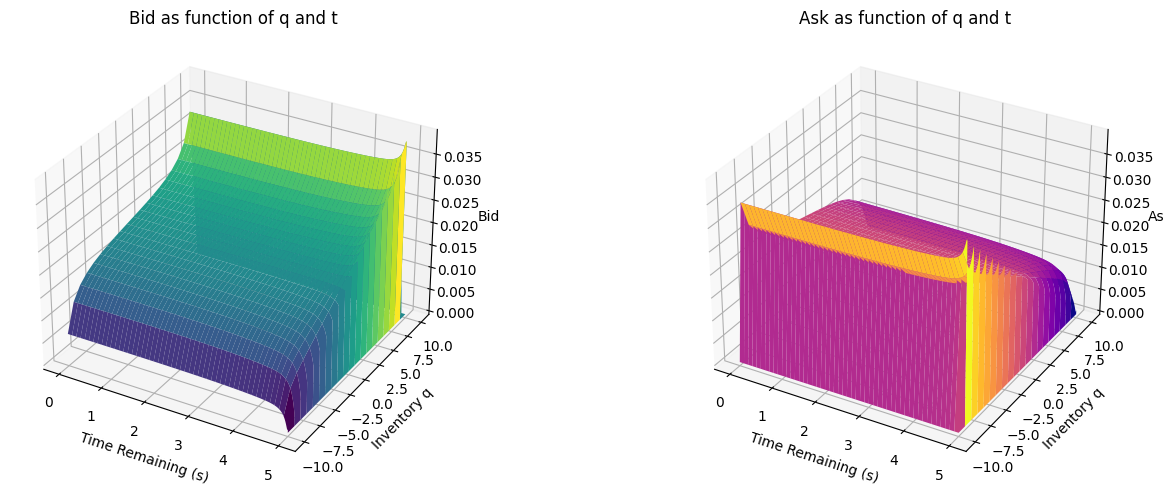

Exponential Model ..


100%|██████████| 50000/50000 [07:37<00:00, 109.18it/s]


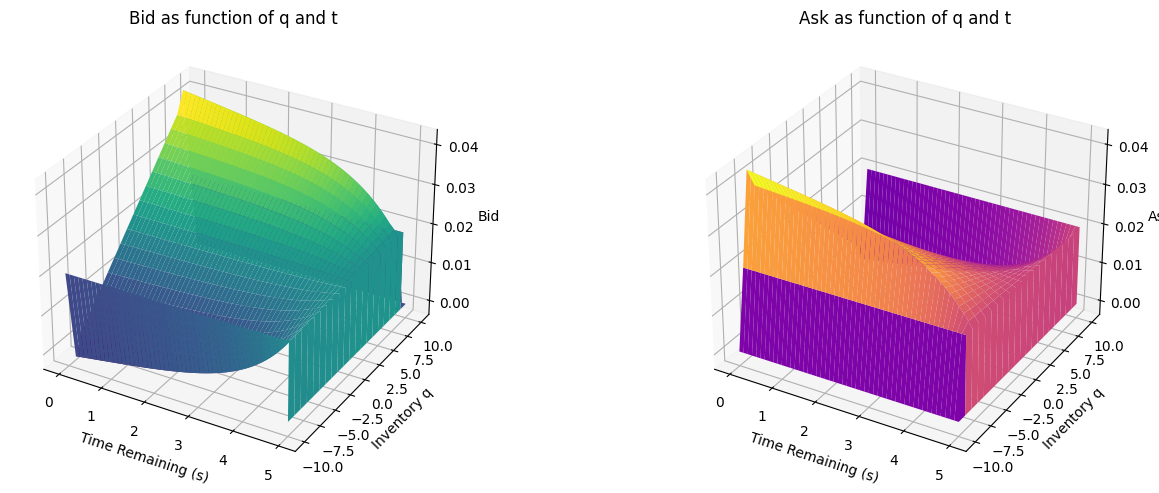

In [6]:
mm_models = Models(params)

Loading Models....


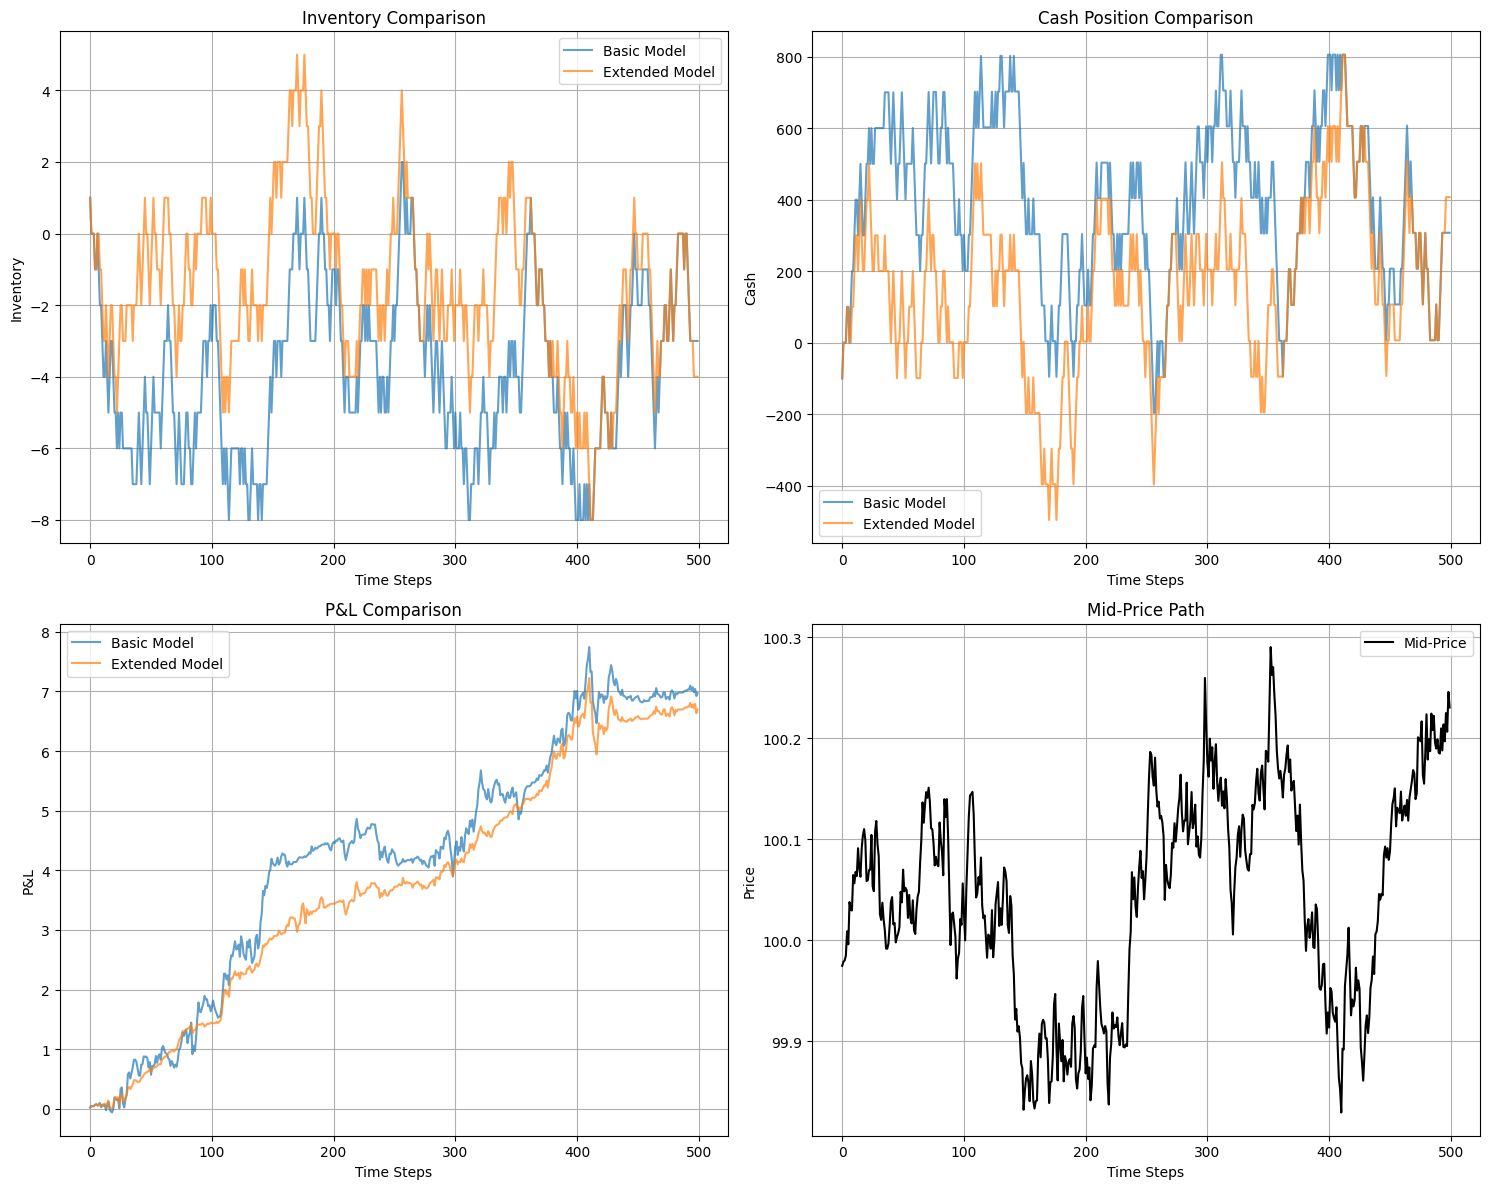


Summary Statistics:
Basic Model - Final P&L: 6.97
Extended Model - Final P&L: 6.70


In [24]:
combined_mm = CombinedMarketMaker(params, mm_models)

# Run combined simulation
basic_results, exp_results, mid_price = combined_mm.simulate_combined_trading()

# Plot comparison
combined_mm.plot_comparison(basic_results, exp_results, mid_price)

In [18]:
# Run combined simulation
basic_pnl = []
exp_pnl = []
for i in range(5000):
    basic_results, exp_results, mid_price = combined_mm.simulate_combined_trading()
    basic_pnl.append(basic_results['pnl'][-1])
    exp_pnl.append(exp_results['pnl'][-1])

# Plot comparison
print("\nSummary Statistics:")
print(f"Basic Model - Average P&L: {np.mean(basic_pnl):.2f}")
print(f"Extended Model - Average P&L: {np.mean(exp_pnl):.2f}")
print(f"\nBasic Model - P&L Std Dev: {np.std(basic_pnl):.2f}")
print(f"Extended Model - P&L Std Dev: {np.std(exp_pnl):.2f}")


Summary Statistics:
Basic Model - Average P&L: 5.91
Extended Model - Average P&L: 6.00

Basic Model - P&L Std Dev: 2.70
Extended Model - P&L Std Dev: 1.68
